In [1]:
import os
import h5py
import numpy as np
import sys
from collections import Counter
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

In [2]:
sample_frequency = 20000
cutoff_frequency=200
filter_order=2

In [3]:
def get_electrode_channel_mapping(raw_data) -> np.array:
    """
    Retrieves electrode-to-channel mapping from the HDF5 file.

    :param raw_data: The HDF5 file data.
    :return: A np.array containing the electrode to channel mapping.
    """
    # Get the clean absolute and relative indices of the spiking information.
    electrode_info = np.asarray(raw_data["mapping"]["channel", "electrode"])
    mask = [i["electrode"] != -1 for i in electrode_info]
    clean_abs_ids = np.asarray([i[0]["electrode"][i[1]] for i in zip(electrode_info, mask)], dtype=np.int32)
    clean_rel_ids = np.asarray([i[0]["channel"][i[1]] for i in zip(electrode_info, mask)], dtype=np.int32)

    # Map the relative indices to the absolute indices of the spiking information
    electrode_channel_mapping = np.zeros([2, clean_rel_ids.shape[0]], dtype=np.int32)
    electrode_channel_mapping[0, :] = np.squeeze(clean_abs_ids)
    electrode_channel_mapping[1, :] = np.squeeze(clean_rel_ids)

    del electrode_info
    del mask
    del clean_abs_ids
    del clean_rel_ids

    return electrode_channel_mapping

In [4]:
raw_path = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Small_Network_Plasticity/2_Raw_Data/Plasticity_Experiments/Raw_Data/BCM_Test/1821/'
recordings = sorted(os.listdir(raw_path))
processed_path = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Small_Network_Plasticity/3_Processed_Data/BCM_Test/1821/'
processed = sorted([f for f in os.listdir(processed_path) if f.endswith('.raw_processed.pkl')])
processed[0],recordings[0]

('ID1821_1_DIV45_DATE20240405_0807_spontaneous_before_BCMFreq_Freq40.raw_processed.pkl',
 'ID1821_1_DIV45_DATE20240405_0807_spontaneous_before_BCMFreq_Freq40.raw.h5')

In [5]:
raw_data = h5py.File(os.path.join(raw_path, recordings[0]), "r")
processed_data = np.load(os.path.join(processed_path, processed[0]), allow_pickle=True)
processed_data['SPIKEMAT']
electrodes = [row[0] for row in processed_data['SPIKEMAT']]
most_common_electrode = Counter(electrodes).most_common(1)[0]
most_common_electrode = most_common_electrode[0]
#most_common_electrode = '12191'


In [6]:
electrode_to_channel = get_electrode_channel_mapping(raw_data)

In [7]:
index = np.where(electrode_to_channel[0] == int(most_common_electrode))[0][0]
electrode_to_channel[1,index]

932

In [8]:
filtered_spike_mat = [row for row in processed_data['SPIKEMAT'] if row[0] == most_common_electrode]
spike_times = np.array([row[1] for row in filtered_spike_mat])
filtered_spike_mat_dist = [row for row in filtered_spike_mat if abs(row[1] - spike_times[0]) < 1.0]


In [9]:
traces = raw_data.get("sig")[np.squeeze(electrode_to_channel[1,index]), :]
if traces.ndim == 1:
    traces = np.expand_dims(traces, axis=0)

In [10]:
nyquist = sample_frequency/2.
cut_off_discrete = cutoff_frequency / nyquist
coeff_b, coeff_a = butter(filter_order, cut_off_discrete, btype="highpass", analog=False)
traces = lfilter(coeff_b, coeff_a, traces)

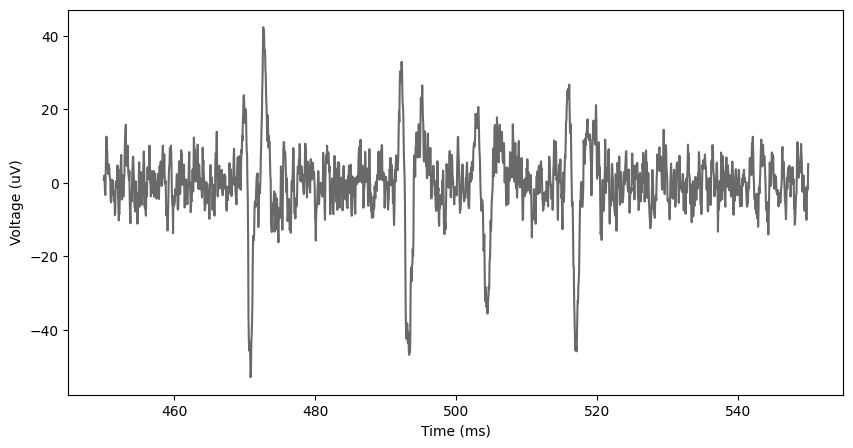

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
beg_idx = 9000
end_idx = 11000
spike_times_int = spike_times[(spike_times > beg_idx/sample_frequency*1000) & (spike_times < end_idx/sample_frequency*1000)]
x_ms = np.arange(0,len(traces[0])/sample_frequency,1/sample_frequency)*1000
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (uV)')
#plt.ylim((-100, 100))
plt.plot(x_ms[beg_idx:end_idx], traces[0][beg_idx:end_idx], color = 'dimgray')
#plt.scatter(spike_times_int, np.ones(len(spike_times_int))*100, color='red')
plt.savefig('spike_times.pdf', dpi = 300)

In [ ]:
spike_times = spike_times[(spike_times > beg_idx/sample_frequency*1000) & (spike_times < end_idx/sample_frequency*1000)]

array([ 0.55502141,  4.3103587 ,  1.99085437, ..., -1.28114011,
       -1.15332189, -2.94509962])